In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ROOT_PATH = "QwenNet"

In [ ]:
import os

constants_path = os.path.join(ROOT_PATH, 'uer', 'utils', 'constants.py')

# Read the content of constants.py
with open(constants_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

modified_lines = []
imported_os = False
for line in lines:
    if 'import os' in line:
        imported_os = True
    if 'with open("models/special_tokens_map.json"' in line:
        modified_line = 'with open(os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(__file__))), "models", "special_tokens_map.json"), mode="r", encoding="utf-8") as f:\n'
        print(f"Original line: {line.strip()}")
        print(f"Modified line: {modified_line.strip()}")
        modified_lines.append(modified_line)
    else:
        modified_lines.append(line)

# Add 'import os' if not already present, at the beginning of the file
if not imported_os:
    modified_lines.insert(0, 'import os\n')
    print("Added 'import os' to constants.py")

# Write the modified content back to constants.py
with open(constants_path, 'w', encoding='utf-8') as f:
    f.writelines(modified_lines)

print(f"Successfully patched {constants_path}")

Original line: with open("models/special_tokens_map.json", mode="r", encoding="utf-8") as f:
Modified line: with open(os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(__file__))), "models", "special_tokens_map.json"), mode="r", encoding="utf-8") as f:
Added 'import os' to constants.py
Successfully patched /content/NetGPT/uer/utils/constants.py


In [ ]:
import os

pretrain_path = os.path.join(ROOT_PATH, 'pretrain.py')

# Read the content of pretrain.py
with open(pretrain_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

modified_lines = []
inserted_local_rank = False
for line in lines:
    modified_lines.append(line)
    if 'trainer.train_and_validate(args)' in line and not inserted_local_rank:
        # Insert args.local_rank = 0 before the call to trainer.train_and_validate
        insert_line = '        args.local_rank = 0 # Default to 0 if not using distributed training\n'
        modified_lines.insert(len(modified_lines) - 1, insert_line)
        print(f"Inserted 'args.local_rank = 0' before trainer.train_and_validate in {pretrain_path}")
        inserted_local_rank = True

# Write the modified content back to pretrain.py
with open(pretrain_path, 'w', encoding='utf-8') as f:
    f.writelines(modified_lines)

print(f"Successfully patched {pretrain_path}")

Inserted 'args.local_rank = 0' before trainer.train_and_validate in /content/drive/MyDrive/NetGPT/pretrain.py
Successfully patched /content/drive/MyDrive/NetGPT/pretrain.py


In [ ]:
!python3 {ROOT_PATH}/pretrain.py   --dataset_path {ROOT_PATH}/distributed/dataset.pt \
                      --vocab_path {ROOT_PATH}/models/encryptd_vocab.txt \
                      --config_path {ROOT_PATH}/models/qwen/config.json \
                      --output_model_path {ROOT_PATH}/pretrained_model.bin \
                      --use_qwen \
                      --qwen_model_name Qwen/Qwen2.5-0.5B \
                      --world_size 1 \
                      --gpu_ranks 0 \
                      --learning_rate 1e-4 \
                      --data_processor lm \
                      --batch_size 32 \
                      --total_steps 10000

python3: can't open file '/content/{ROOT_PATH}/pretrain.py': [Errno 2] No such file or directory


## Fine tuning for Traffic Understanding Tasks

In [ ]:
!python3 {ROOT_PATH}/finetune/run_understanding.py  --pretrained_model_path {ROOT_PATH}/models/pretrained_model.bin-1000 \
                                                  --output_model_path {ROOT_PATH}/models/finetuned_model.bin \
                                                  --vocab_path {ROOT_PATH}/models/encryptd_vocab.txt \
                                                  --config_path {ROOT_PATH}/models/qwen/config.json \
                                                  --use_qwen \
                                                  --qwen_model_name Qwen/Qwen2.5-0.5B \
                                                  --train_path {ROOT_PATH}/understanding_dataset/train_dataset.tsv \
                                                  --dev_path {ROOT_PATH}/understanding_dataset/valid_dataset.tsv \
                                                  --test_path {ROOT_PATH}/understanding_dataset/test_dataset.tsv \
                                                  --epochs_num 2 \
                                                  --batch_size 32 \
                                                  --labels_num 2 \
                                                  --pooling mean

[2025-11-24 17:55:17,809 INFO] Batch size: 32
[2025-11-24 17:55:17,809 INFO] The number of training instances: 80000
[2025-11-24 17:55:22,600 INFO] Start training.
  0% 0/2 [00:00<?, ?it/s][2025-11-24 17:55:22,602 INFO] 2
[2025-11-24 17:56:46,859 INFO] Epoch id: 1, Training steps: 100, Avg loss: 0.196
[2025-11-24 17:58:10,382 INFO] Epoch id: 1, Training steps: 200, Avg loss: 0.001
[2025-11-24 17:59:34,215 INFO] Epoch id: 1, Training steps: 300, Avg loss: 0.000
[2025-11-24 18:00:57,989 INFO] Epoch id: 1, Training steps: 400, Avg loss: 0.000
[2025-11-24 18:02:21,740 INFO] Epoch id: 1, Training steps: 500, Avg loss: 0.000
[2025-11-24 18:03:45,553 INFO] Epoch id: 1, Training steps: 600, Avg loss: 0.000
[2025-11-24 18:05:09,308 INFO] Epoch id: 1, Training steps: 700, Avg loss: 0.000
[2025-11-24 18:06:33,180 INFO] Epoch id: 1, Training steps: 800, Avg loss: 0.000
[2025-11-24 18:07:56,815 INFO] Epoch id: 1, Training steps: 900, Avg loss: 0.012
[2025-11-24 18:09:20,348 INFO] Epoch id: 1, Train

In [ ]:
# Check Fine-tuning Results
import os
import pandas as pd

# Paths
model_path = f"{ROOT_PATH}/models/finetuned_model.bin"
prf_csv_path = f"{ROOT_PATH}/models/prf.csv"  # Precision, Recall, F1 scores

print("=" * 60)
print("FINE-TUNING RESULTS CHECK")
print("=" * 60)

# 1. Check if model was saved
if os.path.exists(model_path):
    file_size = os.path.getsize(model_path) / (1024 * 1024)  # Size in MB
    print(f"✓ Model saved: {model_path} ({file_size:.2f} MB)")
else:
    print(f"✗ Model not found: {model_path}")
    print("  Training may not have completed or model path is different.")

# 2. Check if evaluation results CSV exists
if os.path.exists(prf_csv_path):
    print(f"\n✓ Evaluation results found: {prf_csv_path}")
    print("\nPrecision, Recall, F1 Scores:")
    print("-" * 60)
    df = pd.read_csv(prf_csv_path)
    print(df.to_string(index=False))

    # Calculate overall metrics
    print("\n" + "-" * 60)
    print("Summary Statistics:")
    print(f"Average Precision: {df['Precision'].mean():.4f}")
    print(f"Average Recall: {df['Recall'].mean():.4f}")
    print(f"Average F1: {df['F1'].mean():.4f}")
else:
    print(f"\n✗ Evaluation results not found: {prf_csv_path}")
    print("  Run the fine-tuning script with --test_path to generate results.")

# 3. Check training logs (from cell output above)
print("\n" + "=" * 60)
print("TRAINING LOGS SUMMARY")
print("=" * 60)
print("Check the output of the fine-tuning cell above for:")
print("  - Training loss at each report step")
print("  - Validation accuracy after each epoch")
print("  - Test set confusion matrix")
print("  - Overall test accuracy")

print("\n" + "=" * 60)


FINE-TUNING RESULTS CHECK
✓ Model saved: /content/NetGPT/models/finetuned_model.bin (1222.32 MB)

✓ Evaluation results found: /content/NetGPT/models/prf.csv

Precision, Recall, F1 Scores:
------------------------------------------------------------
 Label num  Precision  Recall  F1
         0        1.0     1.0 1.0
         1        1.0     1.0 1.0

------------------------------------------------------------
Summary Statistics:
Average Precision: 1.0000
Average Recall: 1.0000
Average F1: 1.0000

TRAINING LOGS SUMMARY
Check the output of the fine-tuning cell above for:
  - Training loss at each report step
  - Validation accuracy after each epoch
  - Test set confusion matrix
  - Overall test accuracy



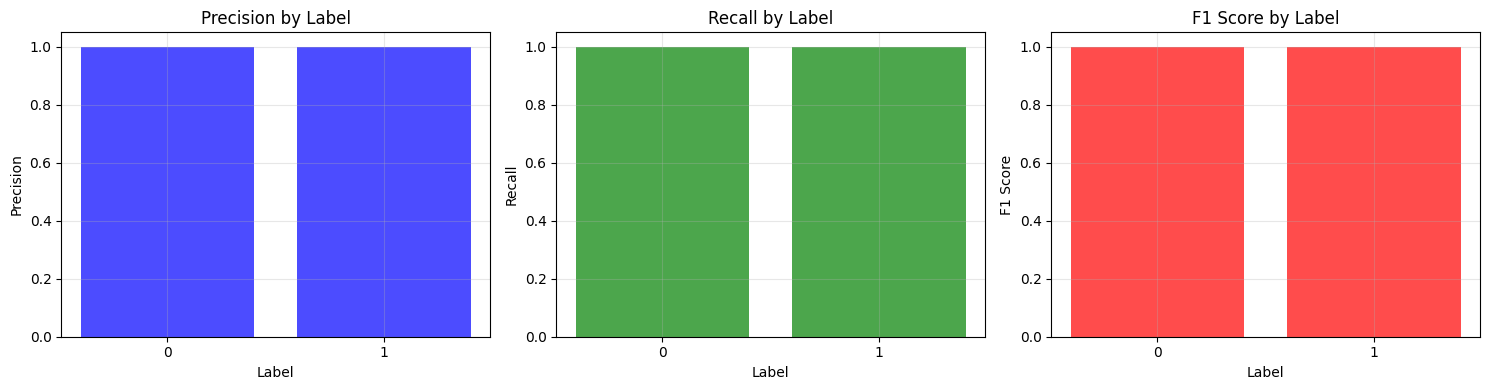


Detailed Metrics:
 Label num  Precision  Recall  F1
         0        1.0     1.0 1.0
         1        1.0     1.0 1.0


In [ ]:
# Optional: Visualize Results and Check Model Performance
import matplotlib.pyplot as plt
import numpy as np

# If results CSV exists, create visualizations
prf_csv_path = f"{ROOT_PATH}/models/prf.csv"

if os.path.exists(prf_csv_path):
    df = pd.read_csv(prf_csv_path)

    # Create a bar plot for metrics
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    labels = df['Label num'].astype(str).tolist()
    x_pos = np.arange(len(labels))

    axes[0].bar(x_pos, df['Precision'], alpha=0.7, color='blue')
    axes[0].set_title('Precision by Label')
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Precision')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(labels)
    axes[0].grid(True, alpha=0.3)

    axes[1].bar(x_pos, df['Recall'], alpha=0.7, color='green')
    axes[1].set_title('Recall by Label')
    axes[1].set_xlabel('Label')
    axes[1].set_ylabel('Recall')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(labels)
    axes[1].grid(True, alpha=0.3)

    axes[2].bar(x_pos, df['F1'], alpha=0.7, color='red')
    axes[2].set_title('F1 Score by Label')
    axes[2].set_xlabel('Label')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(labels)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("\nDetailed Metrics:")
    print(df.to_string(index=False))

else:
    print("Results CSV not found. Run fine-tuning first to generate results.")


## FINE TUNING FOR TRAFFIC GENERATION

In [7]:
!python3 {ROOT_PATH}/finetune/run_generation.py   --pretrained_model_path {ROOT_PATH}/models/pretrained_model.bin-1000 \
                                      --output_model_path {ROOT_PATH}/models/finetuned_model_1.bin \
                                      --vocab_path {ROOT_PATH}/models/encryptd_vocab.txt \
                                      --config_path {ROOT_PATH}/models/qwen/config.json \
                                      --use_qwen \
                                      --qwen_model_name Qwen/Qwen2.5-0.5B \
                                      --train_path {ROOT_PATH}/generation_dataset/train_dataset.tsv \
                                      --dev_path {ROOT_PATH}/generation_dataset/valid_dataset.tsv \
                                      --test_path {ROOT_PATH}/generation_dataset/test_dataset.tsv \
                                      --learning_rate 1e-5 \
                                      --epochs_num 2 \
                                      --batch_size 16 \
                                      --pooling mean \
                                      --seq_length 256 \
                                      --tgt_seq_length 4

[2025-11-24 20:44:20,326 INFO] Batch size: 16
[2025-11-24 20:44:20,326 INFO] The number of training instances: 59189
[2025-11-24 20:44:25,413 INFO] Start training.
[2025-11-24 20:45:31,270 INFO] Epoch id: 1, Training steps: 100, Avg loss: 4.227
[2025-11-24 20:46:33,383 INFO] Epoch id: 1, Training steps: 200, Avg loss: 1.107
[2025-11-24 20:47:35,508 INFO] Epoch id: 1, Training steps: 300, Avg loss: 0.925
[2025-11-24 20:48:37,643 INFO] Epoch id: 1, Training steps: 400, Avg loss: 0.848
[2025-11-24 20:49:39,701 INFO] Epoch id: 1, Training steps: 500, Avg loss: 0.770
[2025-11-24 20:50:41,802 INFO] Epoch id: 1, Training steps: 600, Avg loss: 0.679
[2025-11-24 20:51:43,857 INFO] Epoch id: 1, Training steps: 700, Avg loss: 0.603
[2025-11-24 20:52:45,953 INFO] Epoch id: 1, Training steps: 800, Avg loss: 0.551
[2025-11-24 20:53:48,110 INFO] Epoch id: 1, Training steps: 900, Avg loss: 0.579
[2025-11-24 20:54:50,153 INFO] Epoch id: 1, Training steps: 1000, Avg loss: 0.522
[2025-11-24 20:55:52,072 